# Computes Transmission Spectra

We compute a high-resolution transmission spectrum using HITRAN CO and compare it with the results by the different method (by Yui Kawashima).
Note that `ArtTransPure` is `art` for the transmission spectrum.

In [ ]:
import pandas as pd
import numpy as np
from exojax.utils.grids import wavenumber_grid
from exojax.utils.astrofunc import gravity_jupiter
from exojax.spec.opacalc import OpaPremodit
from exojax.spec.atmrt import ArtTransPure
from exojax.utils.constants import RJ, Rs
from exojax.spec.api import MdbHitran

from jax import config  

config.update("jax_enable_x64", True)

/home/kawahara/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:13: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


To load a reference spectrum, we make the following method.

In [2]:
def read_kawashima_data(filename):
    dat = pd.read_csv(filename, delimiter="   ")
    wav = dat["Wavelength[um]"]
    mask = (wav > 2.25) & (wav < 2.6)
    return wav[mask], dat["Rp/Rs"][mask]


The ref file should be in ExoJAX repo.

In [3]:
filename = "/home/kawahara/exojax/tests/integration/comparison/transmission/spectrum/CO100percent_500K.dat"

Here is the core code. We define `art` using `ArtTransPure`. 
`art.constant_mmr_profile` sets the mass mixing ratio layer profile to a constant value. Here we assume 100% CO everywhere.
For a transmission spectrum, the constant gravity assumption is not good approximation. So, we need to compute the gravity profile. 
`art.gravity_profile` does it. After computing opacity, we can use `art.run` to generate the transmission spectrum.

In [29]:
def compare_with_kawashima_code():
    mu_fid = 28.00863  # mean molecular weight
    T_fid = 500.0

    Nx = 50000
    nu_grid, wav, res = wavenumber_grid(
        22900.0, 24000.0, Nx, unit="AA", xsmode="premodit"
    )

    art = ArtTransPure(pressure_top=1.0e-15, pressure_btm=1.0e1, nlayer=100)
    art.change_temperature_range(490.0, 510.0)
    Tarr = T_fid * np.ones_like(art.pressure)
    mmr_arr = art.constant_mmr_profile(1.0)
    gravity_btm = gravity_jupiter(1.0, 1.0)
    radius_btm = RJ

    mdb_iso1 = MdbHitran("CO", nu_grid, gpu_transfer=False, isotope=1)
    mdb_iso2 = MdbHitran("CO", nu_grid, gpu_transfer=False, isotope=2)
    mdb_iso4 = MdbHitran("CO", nu_grid, gpu_transfer=False, isotope=4)
    
    mmw = mu_fid * np.ones_like(art.pressure)
    gravity = art.gravity_profile(Tarr, mmw, radius_btm, gravity_btm)

    # We include C12 16O, C13 16O, and C12 17O
    opa_iso1 = OpaPremodit(
        mdb=mdb_iso1, nu_grid=nu_grid, auto_trange=[T_fid - 10.0, T_fid + 10.0]
    )
    opa_iso2 = OpaPremodit(
        mdb=mdb_iso2, nu_grid=nu_grid, auto_trange=[T_fid - 10.0, T_fid + 10.0]
    )
    opa_iso4 = OpaPremodit(
        mdb=mdb_iso4, nu_grid=nu_grid, auto_trange=[T_fid - 10.0, T_fid + 10.0]
    )
    
    xsmatrix_iso1 = opa_iso1.xsmatrix(Tarr, art.pressure)
    xsmatrix_iso2 = opa_iso2.xsmatrix(Tarr, art.pressure)
    xsmatrix_iso4 = opa_iso4.xsmatrix(Tarr, art.pressure)
    xsmatrix = xsmatrix_iso1 + xsmatrix_iso2 + xsmatrix_iso4
    dtau = art.opacity_profile_xs(xsmatrix, mmr_arr, opa_iso1.mdb.molmass, gravity)

    Rp2 = art.run(dtau, Tarr, mmw, radius_btm, gravity_btm)
    return nu_grid, np.sqrt(Rp2) * radius_btm / Rs

Compares the results. Not so bad. 

/tmp/ipykernel_9525/4154571916.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dat = pd.read_csv(filename, delimiter="   ")
/home/kawahara/exojax/src/exojax/spec/unitconvert.py:62: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/atmrt.py:53: UserWarning: nu_grid is not given. specify nu_grid when using 'run' 
  warnings.warn(


xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: xsmode=premodit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
integration:  simpson
Simpson integration, uses the chord optical depth at the lower boundary and midppoint of the layers.
radis engine =  vaex
radis engine =  vaex
radis engine =  vaex
OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 485.78039920454563 - 680.34913472759 K
OpaPremodit: Tref_broadening is set to  499.89998999799934 K
OpaPremodit: gamma_air and n_air are used. gamma_ref = gamma_air/Patm
# of reference width grid :  7
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 5/5 [00:00<00:00, 8852.48it/s]

Premodit: Twt= 637.741375149819 K Tref= 510.72954778036876 K
Making LSD:|####################| 100%
OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2


Robust range: 485.78039920454563 - 680.34913472759 K
OpaPremodit: Tref_broadening is set to  499.89998999799934 K
OpaPremodit: gamma_air and n_air are used. gamma_ref = gamma_air/Patm
# of reference width grid :  7
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 5/5 [00:00<00:00, 31679.03it/s]


Premodit: Twt= 637.741375149819 K Tref= 510.72954778036876 K
Making LSD:|####################| 100%
OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 485.78039920454563 - 680.34913472759 K
OpaPremodit: Tref_broadening is set to  499.89998999799934 K
OpaPremodit: gamma_air and n_air are used. gamma_ref = gamma_air/Patm
# of reference width grid :  6
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 4/4 [00:00<00:00, 24745.16it/s]


Premodit: Twt= 637.741375149819 K Tref= 510.72954778036876 K
Making LSD:|####################| 100%


/home/kawahara/exojax/src/exojax/spec/unitconvert.py:62: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(


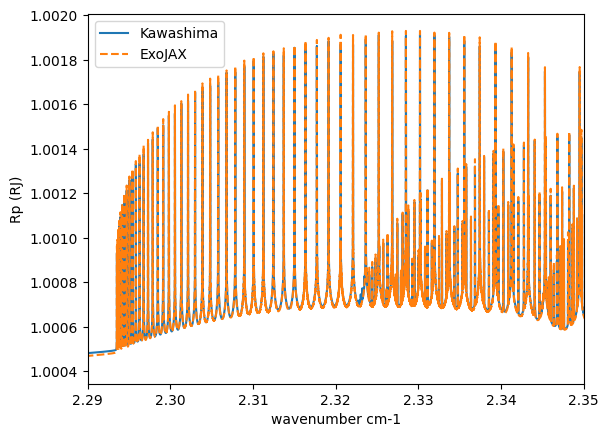

In [30]:
import matplotlib.pyplot as plt

wav, rprs = read_kawashima_data(filename)
diffmode = 1
nus_hitran, Rp_hitran = compare_with_kawashima_code()
from exojax.spec.unitconvert import nu2wav
wav_exojax = nu2wav(nus_hitran, unit="um", wavelength_order="ascending")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(wav, rprs * Rs / RJ, label="Kawashima")
ax.plot(wav_exojax[::-1], Rp_hitran * Rs / RJ, label="ExoJAX",ls="dashed")
plt.legend()
plt.xlabel("wavenumber cm-1")
plt.legend()
plt.ylabel("Rp (RJ)")
plt.xlim(2.29,2.35)
plt.savefig("comparison_iso.png")
plt.show()
